# Do Timestamps Match up?

Timestamp Test comparing monocular ximea camera captured using Ximea Plugin for Pupil Capture with Intel Realsesense camera recorded in parallel

In [1]:
import imp
import run_analysis as ana
from ximea import xiapi
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

import ximea_cam_aquire_save as xim

from time import sleep, time
import pupil_cam_aquire_save as pup
import zmq_socket as zmqs
#import pupil_src.shared_modules.file_methods as pupfm
import threading

## Paths for Timestamps Files

In [16]:
#base_path = '/home/vasha/recordings'
base_path = '/mnt/recordings'

date = '2020_03_18'
rnumber = '010'
subject_name = 'TEST_SUBJECT'
task_name = 'TEST_TASK'

realsense_framerate = 90.
ximea_framerate = 200.
framerate = 200.

realsense_path = f'{base_path}/{date}/{rnumber}'
rs_d_timestamp_path = os.path.join(realsense_path,'depth/timestamps.csv')
#rs_d_movie_path = os.path.join(realsense_path,'depth.mp4') #now saved as numpy frames
rs_c_timestamp_path = os.path.join(realsense_path,'world_timestamps.npy')
rs_c_movie_path = os.path.join(realsense_path,'world.mp4')

ximea_path = f'{base_path}/{date}/{rnumber}/ximea'
xim_timestamp_path = os.path.join(ximea_path,'timestamps_ximea.tsv')
xim_timestamp_sync_path = os.path.join(ximea_path,'timestamp_camsync_ximea.tsv')
xim_movie_path = os.path.join(ximea_path,'ximea')

ximea_path = f'{base_path}/{date}/{rnumber}/ximea'
xim_timestamp_path = os.path.join(ximea_path,'timestamps_ximea.tsv')
xim_timestamp_sync_path = os.path.join(ximea_path,'timestamp_camsync_ximea.tsv')
xim_movie_path = os.path.join(ximea_path,'ximea')

tracker_timestamp_path = os.path.join(realsense_path,'odometry_timestamps.npy')

analysis_folder = './test_timestamps/analysis'

### Pupil Cams

In [17]:
pupil_ts = np.load(os.path.join(realsense_path, 'pupil_timestamps.npy'))
gaze_ts = np.load(os.path.join(realsense_path, 'gaze_timestamps.npy'))
pupil_0_ts = np.load(os.path.join(realsense_path,'eye0_timestamps.npy'))
pupil_1_ts = np.load(os.path.join(realsense_path,'eye1_timestamps.npy'))
print(f'{len(gaze_ts)} Gaze Timestamps: {gaze_ts[0]} : {gaze_ts[-1]}')
print(f'{len(pupil_ts)} Pupil Timestamps: {pupil_ts[0]} : {pupil_ts[-1]}')
print(f'{len(pupil_0_ts)} Pupil 1 Timestamps: {pupil_0_ts[0]} : {pupil_0_ts[-1]}')
print(f'{len(pupil_1_ts)} Pupil 2 Timestamps: {pupil_1_ts[0]} : {pupil_1_ts[-1]}')

2307 Gaze Timestamps: 399.464327 : 405.246864
2307 Pupil Timestamps: 399.464327 : 405.246864
1133 Pupil 1 Timestamps: 399.599503 : 405.26689
1128 Pupil 2 Timestamps: 399.596169 : 405.263556


## Frame Skips

xim missed frames total: 4.0 / 1129 = 0.35%


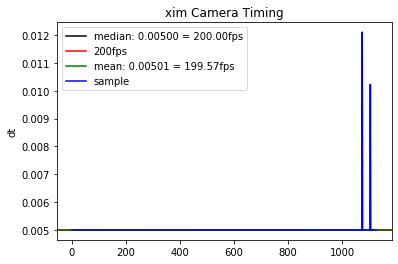

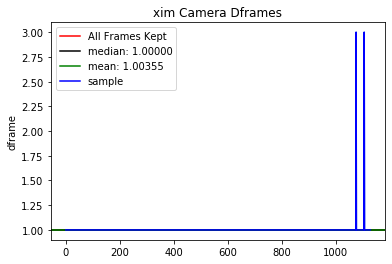

In [18]:
imp.reload(ana)
ana.count_missed_frames(xim_timestamp_path, 'xim')
ana.plot_camera_timing(xim_timestamp_path, './test_timestamps/timestamps_plot_xim.png', 'xim')
ana.plot_camera_dframe(xim_timestamp_path, './test_timestamps/timestamps_plot_xim.png', 'xim')

## Convert Ximea to Wall clock time

In [19]:
imp.reload(ana)
tb, tb_cols = ana.convert_ximea_time_to_unix_and_pl_time(xim_timestamp_path, xim_timestamp_sync_path)

print(tb_cols)
print(tb[0])

Time Elapsed Cam: 5.646599847999994 seconds
Time Elapsed Pupil: 5.646283542499987 seconds
Time Elapsed Unix: 5.646283388137817 seconds
Time Drift cam vs pupil: 0.00031630550000727453 seconds
Time Drift cam vs unix: 0.00031645986217654354 seconds
Time Drift unix vs pupil: 1.543621692690067e-07 seconds
['frame_number', 'xim_count', 'timestamps_ximea', 'timestamps_convert_unix', 'timestamps_convert_plsync', 'timestamps_unix_adjusted']
[0.00000000e+00 1.15500000e+03 4.05209747e+02 1.58458683e+09
 3.99634049e+02 3.99634049e+02]


In [20]:
imp.reload(ana)
ximea_timestamps_table, ximea_timestamps_labels = ana.convert_ximea_time_to_unix_and_pl_time(xim_timestamp_path, xim_timestamp_sync_path)
ximea_unix_timestamps = ximea_timestamps_table[:,5]
ximea_pupilsync_timestamps = ximea_timestamps_table[:,4]

ximea_timestamp_converted_path = os.path.join(analysis_folder,'timestamps_converted.tsv')

#np.savetxt(od_ximea_timestamp_converted_path, od_ximea_timestamps, fmt='%10.5f', delimiter='\t')
np.savetxt(ximea_timestamp_converted_path, ximea_timestamps_table, fmt='%10.5f', delimiter='\t')

Time Elapsed Cam: 5.646599847999994 seconds
Time Elapsed Pupil: 5.646283542499987 seconds
Time Elapsed Unix: 5.646283388137817 seconds
Time Drift cam vs pupil: 0.00031630550000727453 seconds
Time Drift cam vs unix: 0.00031645986217654354 seconds
Time Drift unix vs pupil: 1.543621692690067e-07 seconds


## Load in All Timestamps
TODO: Include Tracker Data

In [21]:
tracker_timestamp_path

'/mnt/recordings/2020_03_18/010/odometry_timestamps.npy'

In [22]:
rs_c_timestamps = np.load(rs_c_timestamp_path)
ximea_timestamps = ximea_unix_timestamps
ximea_timestamps = ximea_pupilsync_timestamps
rs_d_timestamps = np.loadtxt(rs_d_timestamp_path)
#rs_d_timestamps = rs_c_timestamps
#tracker_timestamps = np.load(tracker_timestamp_path)


xim_true_framerate = len(ximea_timestamps)/(ximea_timestamps[-1]-ximea_timestamps[0])
rs_c_true_framerate = len(rs_c_timestamps)/(rs_c_timestamps[-1]-rs_c_timestamps[0])
rs_d_true_framerate = len(rs_d_timestamps)/(rs_d_timestamps[-1]-rs_d_timestamps[0])
#tracker_true_framerate = len(tracker_timestamps)/(tracker_timestamps[-1]-tracker_timestamps[0])

#print(f'{len(ximea_timestamps)} Ximea Timestamps: {ximea_timestamps[0]} : {ximea_timestamps[-1]}, estimated {xim_true_framerate} Hz')
print(f'{len(rs_d_timestamps)} Realsense Depth Timestamps: {rs_d_timestamps[0]} : {rs_d_timestamps[-1]}, estimated {rs_d_true_framerate} Hz')
print(f'{len(rs_c_timestamps)} Realsense Color Timestamps: {rs_c_timestamps[0]} : {rs_c_timestamps[-1]}, estimated {rs_c_true_framerate} Hz')
#print(f'{len(tracker_timestamps)} Tracker Timestamps: {tracker_timestamps[0]} : {tracker_timestamps[-1]}, estimated {tracker_true_framerate} Hz')


184 Realsense Depth Timestamps: 399.650005765 : 405.274414677, estimated 32.71454883150941 Hz
94 Realsense Color Timestamps: 399.621033835 : 405.19440283, estimated 16.865920789441617 Hz


## Assign All Movies to Uniform Timeline

Text(0.5, 1.0, 'Timeline Comparisons Pre-Reassignment')

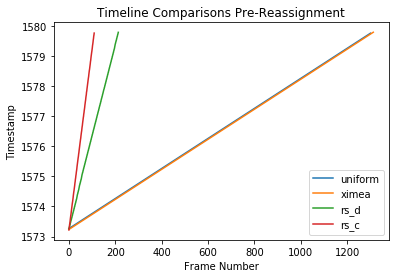

In [85]:
start_list = (ximea_timestamps[0],
              rs_d_timestamps[0],
              rs_c_timestamps[0])
              #tracker_timestamps[0])

end_list = (ximea_timestamps[-1],
            rs_d_timestamps[-1],
            rs_c_timestamps[-1])
           #tracker_timestamps[-1])

timeline_start = np.max(start_list)
timeline_end = np.min(end_list)
timeline = np.arange(timeline_start, timeline_end, 1./framerate)
plt.plot(timeline, label='uniform')
plt.plot(ximea_timestamps, label='ximea')
plt.plot(rs_d_timestamps, label='rs_d')
plt.plot(rs_c_timestamps, label='rs_c')
#plt.plot(tracker_timestamps, label='rs_tracker')
plt.xlabel('Frame Number')
plt.ylabel('Timestamp')
plt.legend()
plt.title('Timeline Comparisons Pre-Reassignment')

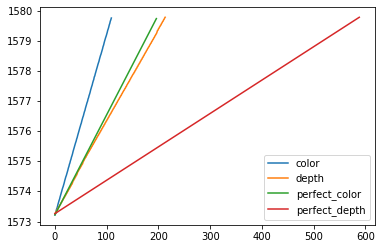

In [86]:
framerate = 30
timeline_start = np.max((rs_c_timestamps[0], rs_c_timestamps[0], rs_c_timestamps[0]))
timeline_end = np.min((rs_c_timestamps[-1], rs_c_timestamps[-1], rs_c_timestamps[-1]))
timeline_c = np.arange(timeline_start, timeline_end, 1./framerate)

framerate = 90
timeline_start = rs_d_timestamps[0]
timeline_end = rs_d_timestamps[-1]
timeline_d = np.arange(timeline_start, timeline_end, 1./framerate)

plt.plot(rs_c_timestamps, label='color')
plt.plot(rs_d_timestamps, label='depth')
plt.plot(timeline_c, label='perfect_color')
plt.plot(timeline_d, label='perfect_depth')

plt.legend()

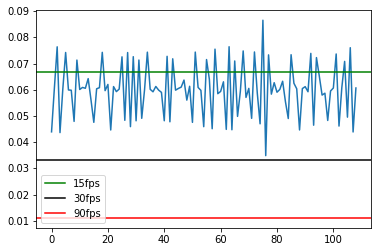

In [87]:
plt.plot(rs_c_timestamps[1:] - rs_c_timestamps[:-1])
plt.axhline(1/15, c='g', label='15fps')
plt.axhline(1/30, c='k', label='30fps')
plt.axhline(1/90, c='r', label='90fps')
plt.legend()

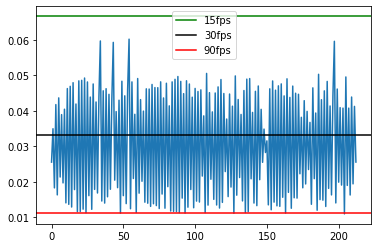

In [88]:
plt.plot(rs_d_timestamps[1:] - rs_d_timestamps[:-1])
plt.axhline(1/15, c='g', label='15fps')
plt.axhline(1/30, c='k', label='30fps')
plt.axhline(1/90, c='r', label='90fps')
plt.legend()

In [14]:
print(1/90, 1/45)


0.011111111111111112 0.022222222222222223


In [15]:
def reassign_timeline(orig_timeline, new_timeline):
    '''
    Given two timelines, original and new, find the closest match
    between the two, and assign the temporally closest indexes of
    the original timeline in the new one. 
    *NOTE*: This likely involves duplication and/or dropping of frames
    ''' 
    closest_frame = [np.argmin(np.abs(new-orig_timeline)) for new in new_timeline]
    return(closest_frame)

ximea_frame_order = reassign_timeline(ximea_timestamps, timeline)
rs_d_frame_order = reassign_timeline(rs_d_timestamps, timeline)
rs_c_frame_order = reassign_timeline(rs_c_timestamps, timeline)
pup_0_frame_order = reassign_timeline(pupil_0_ts, timeline)
pup_1_frame_order = reassign_timeline(pupil_1_ts, timeline)


#set timeline to start at zero
timeline = timeline - timeline[0]

Ximea and Realsense timestamps look pretty similar. Let's see if the frames line up.

## Compare Frames 
Compare the ximea and realsense frames 

52 4 5


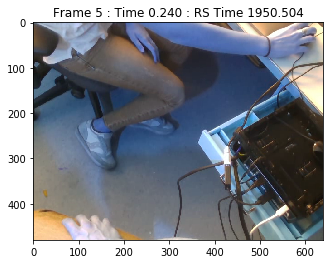

In [19]:
#time = 1.53
#frame_number = int(round(time*framerate))

time = 0.24
frame_number = np.argmin(np.abs(time - timeline))
xi_fnum = ximea_frame_order[frame_number]
rs_d_fnum = rs_d_frame_order[frame_number]
rs_c_fnum = rs_c_frame_order[frame_number]

print(xi_fnum, rs_d_fnum, rs_c_fnum)

fn = rs_c_frame_order[frame_number]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()


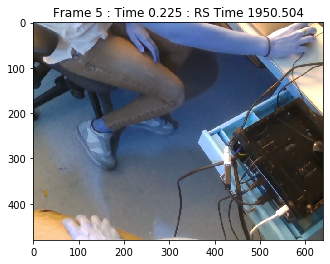

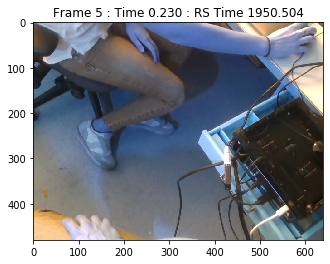

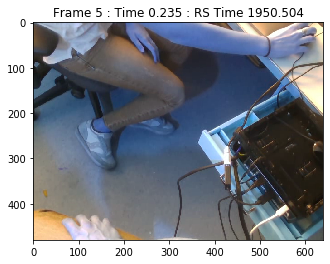

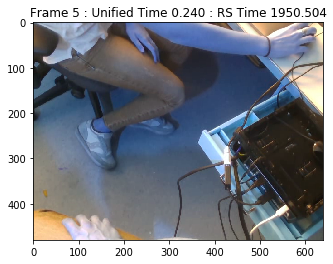

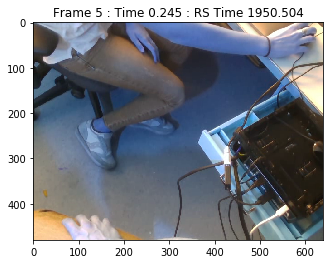

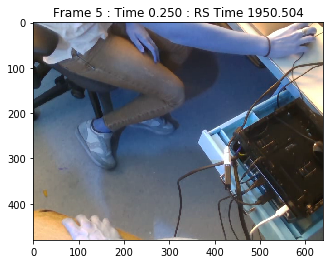

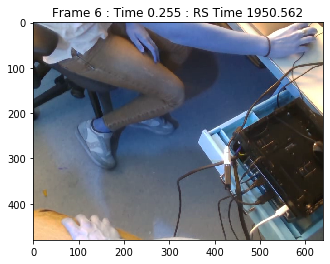

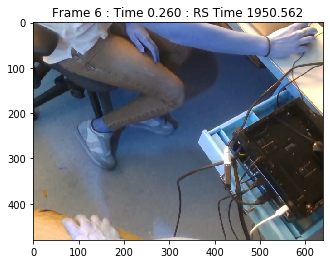

In [20]:
fn = rs_c_frame_order[frame_number-3]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-3]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number-2]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-2]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number-1]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-1]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Unified Time {timeline[frame_number]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()   

fn = rs_c_frame_order[frame_number+1]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+1]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number+2]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+2]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number+3]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+3]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number+4]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+4]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

In [ ]:
fn = ximea_frame_order[frame_number-5]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 4000, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-5]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number-4]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-4]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number-3]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-3]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number-2]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-2]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number-1]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-1]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number+1]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+1]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number+2]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+2]:0.3f}: Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number+3]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+3]:0.3f}: Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number+4]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+4]:0.3f}: Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

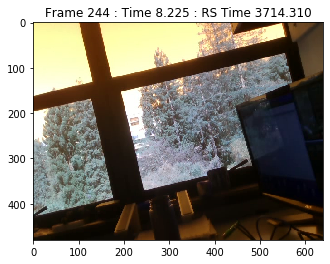

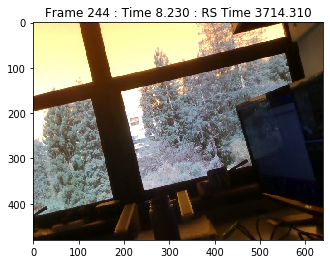

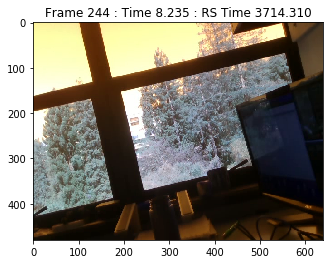

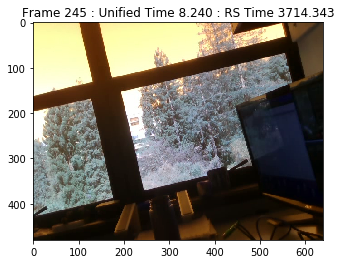

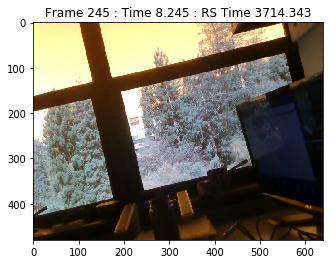

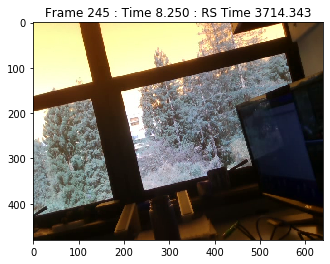

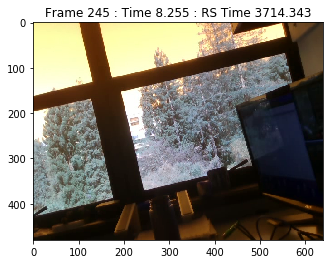

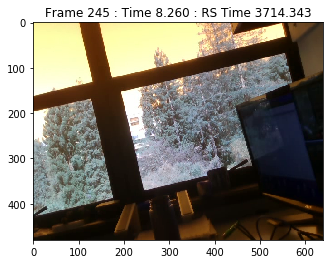

In [16]:
fn = rs_c_frame_order[frame_number-3]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-3]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number-2]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-2]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number-1]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-1]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Unified Time {timeline[frame_number]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()   

fn = rs_c_frame_order[frame_number+1]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+1]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number+2]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+2]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number+3]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+3]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number+4]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+4]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

36126 14924 5171


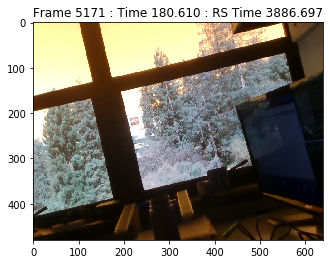

In [17]:
#time = 1.53
#frame_number = int(round(time*framerate))

time = 454.14
frame_number = np.argmin(np.abs(time - timeline))
xi_fnum = ximea_frame_order[frame_number]
rs_d_fnum = rs_d_frame_order[frame_number]
rs_c_fnum = rs_c_frame_order[frame_number]

print(xi_fnum, rs_d_fnum, rs_c_fnum)

fn = rs_c_frame_order[frame_number]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()


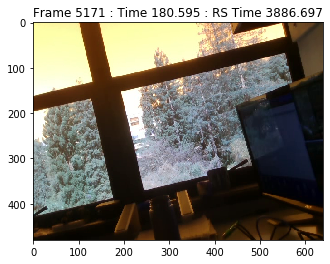

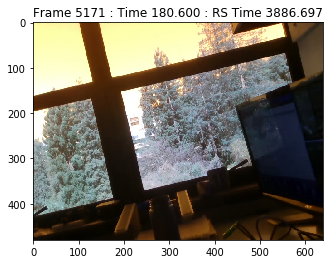

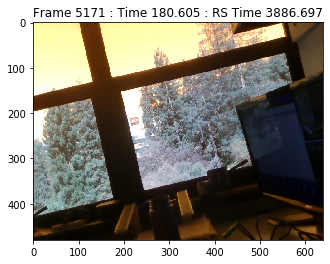

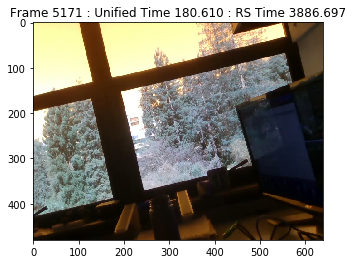

IndexError: list index out of range

In [18]:
fn = rs_c_frame_order[frame_number-3]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-3]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number-2]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-2]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number-1]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-1]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Unified Time {timeline[frame_number]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()   

fn = rs_c_frame_order[frame_number+1]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+1]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number+2]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+2]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number+3]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+3]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

fn = rs_c_frame_order[frame_number+4]
rs_frame = ana.pupil_get_frame(rs_c_movie_path, fn)
plt.imshow(rs_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+4]:0.3f} : RS Time {rs_c_timestamps[fn]:0.3f}')
plt.show()

In [ ]:
fn = ximea_frame_order[frame_number-5]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-5]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number-4]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-4]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number-3]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-3]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number-2]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-2]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number-1]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number-1]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number+1]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+1]:0.3f} : Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number+2]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+2]:0.3f}: Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number+3]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+3]:0.3f}: Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

fn = ximea_frame_order[frame_number+4]
xi_frame = np.fliplr(np.flipud(ana.ximea_get_frame(fn, 200, '', xim_movie_path)))
plt.imshow(xi_frame)
plt.title(f'Frame {fn} : Time {timeline[frame_number+4]:0.3f}: Xim Time {ximea_timestamps[fn]:0.3f}')
plt.show()

In [ ]:
rs_frame = ana.pupil_get_frame(rs_c_movie_path, rs_c_fnum-1)
plt.imshow(rs_frame)
plt.title(f'Frame {rs_c_fnum-1}: ')
plt.show()

rs_frame = ana.pupil_get_frame(rs_c_movie_path, rs_c_fnum)
plt.imshow(rs_frame)
plt.title(f'Frame {rs_c_fnum}')
plt.show()

rs_frame = ana.pupil_get_frame(rs_c_movie_path, rs_c_fnum+1)
plt.imshow(rs_frame)
plt.title(f'Frame {rs_c_fnum+1}')

In [ ]:
os.path.join(pupil_save_dir_name, rnumber, 'pupil_timestamps.npy')

In [ ]:
pupil_ts = np.load(os.path.join(pupil_save_dir_name, rnumber, 'pupil_timestamps.npy'))
pupil_ts_eye_a = pupil_ts[::2]
pupil_ts_eye_b = pupil_ts[1::2]

In [ ]:
pupil_ts_eye_a

In [ ]:
pupil_ts = np.load(os.path.join(pupil_save_dir_name, rnumber, 'pupil_timestamps.npy'))
pupil_ts_eye_a = pupil_ts[::2]
pupil_ts_eye_b = pupil_ts[1::2]
#pupil_ts_gaze = np.load(os.path.join(pupil_save_dir_name, rnumber, 'gaze_timestamps.npy'))
pupil_ts_eye0 = np.load(os.path.join(pupil_save_dir_name, rnumber, 'eye0_timestamps.npy'))
pupil_ts_eye1 = np.load(os.path.join(pupil_save_dir_name, rnumber, 'eye1_timestamps.npy'))
pupil_annotations = np.load(os.path.join(pupil_save_dir_name, rnumber, 'annotation_timestamps.npy'))

#ximea timestamps
with open(ximea_timestamp_converted_path, 'r') as f:
    timestamps_ximea = list(zip(line.strip().split('\t') for line in f))
    timestamps_ximea = np.squeeze(np.array(timestamps_ximea[1:]).astype('float'))
    timestamps_ximea = timestamps_ximea[:,-1]

linear_ximea = np.arange(0,collection_mins*200*60*0.005, 0.005)+timestamps_ximea[0]
linear_pupil = np.arange(0, collection_mins*200*60*0.005, 0.005)+pupil_ts[0]

plt.figure(figsize=(8,8))
plt.plot(timestamps_ximea, label='ximea')
plt.plot(pupil_ts_eye_a, label='pupil_a')
plt.plot(pupil_ts_eye_b, label='pupil_b')
#plt.plot(pupil_ts_gaze, label='gaze')
plt.plot(pupil_ts_eye0, label='vid_eye0')
plt.plot(pupil_ts_eye1, label='vid_eye1')
plt.plot(linear_ximea, label='linear_ximea')
#plt.plot(linear_pupil, label='linear_pupil')
plt.legend()
plt.xlabel('Frame Number')
plt.ylabel('Timestamp')
plt.title('Timestamp Lag')
plt.legend()

In [ ]:
pupil_ts_eye_a[0],pupil_ts_eye_a[1]

In [ ]:
timestamps_ximea[0],timestamps_ximea[1], 

In [ ]:
linear_pupil[0] - pupil_ts_eye_a[0]

In [ ]:
linear_pupil[5970] - pupil_ts_eye_a[5970]

In [ ]:
linear_pupil[400] - pupil_ts_eye_a[400]

In [ ]:
linear_pupil[5970] - pupil_ts_eye_a[5970]

In [ ]:
print(len(linear_ximea))
print(len(pupil_ts_eye_a))


In [ ]:
print(len(timestamps_ximea), len(linear_ximea))

In [ ]:
timestamps_ximea[0] - linear_ximea[0]

In [ ]:
timestamps_ximea[100] - linear_ximea[100]

In [ ]:
timestamps_ximea[1000] - linear_ximea[1000]

In [ ]:
timestamps_ximea[23828] - linear_ximea[23828]

In [ ]:
len(ximea_ts)

In [ ]:
pupil_ts[0]

In [ ]:
pupil_ts[1]

In [ ]:
pupil_ts[2]

In [ ]:
pupil_ts[3]

In [ ]:
timestamps_ximea[0] - pupil_ts_eye0[0]

In [ ]:
timestamps_ximea[47500] - pupil_ts_eye0[47500]

In [ ]:
timestamps_ximea[47500] - pupil_ts_eye0[47500]

In [ ]:
timestamps_ximea[0]

In [ ]:
timestamps_ximea[1]

In [ ]:
timestamps_ximea[2]

In [ ]:
print(pupil_ts_eye0[0])
print(pupil_ts_eye1[0])


In [ ]:
pupil_ts_eye0[1]

In [ ]:
pupil_ts_eye0[2]

In [ ]:
timestamps_ximea

In [ ]:
pupil_ts = np.load(os.path.join(pupil_save_dir_name, rnumber, 'pupil_timestamps.npy'))
pupil_ts_file_eye0 = os.path.join(pupil_save_dir_name, rnumber, 'eye0_timestamps.npy')
pupil_ts_file_eye1 = os.path.join(pupil_save_dir_name, rnumber, 'eye1_timestamps.npy')


    
#pupil timestamps
ts_pupil = np.load(pupil_ts)
timestamps_pupil_eye0 = np.load(pupil_ts_file_eye0)
timestamps_pupil_eye1 = np.load(pupil_ts_file_eye1)


plt.plot(ts_pupil,label='pupil')
plt.plot(timestamps_pupil_eye1,label='pupil_eye1')
plt.plot(timestamps_pupil_eye0,label='pupil_eye0')
plt.plot(timestamps_ximea,label='ximea')


In [ ]:
ximea_timestamp_converted_path

## Find Image of Two Ximea Cameras near Turn-off Point

In [ ]:
imp.reload(ana)
target_framenum = 1000
target_timestamp = ana.ximea_framenum_to_timestamp(ximea_timestamp_converted_path, target_framenum)

frame, ts = ana.ximea_timestamp_to_framenum(ximea_timestamp_converted_path, target_timestamp)

ts_pre = ana.ximea_framenum_to_timestamp(ximea_timestamp_converted_path, frame-1) #reverse
ts_post = ana.ximea_framenum_to_timestamp(ximea_timestamp_converted_path, frame+1) #reverse


In [ ]:
#img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
img_cy_pre = ana.ximea_get_frame(frame_cy-1, save_batchsize, 'cy', ximea_save_folder_list[0])
img_cy = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[0])
img_cy_post = ana.ximea_get_frame(frame_cy+1, save_batchsize, 'cy', ximea_save_folder_list[0])

#plt.imshow(img_od)
#plt.title(f'OD: frame_num={frame_od}, ts={ts_od}')
#plt.show()
plt.figure(figsize=(10,13))
plt.imshow(img_cy_pre)
plt.title(f'PRE CY: frame_num={frame_cy-1}, ts={ts_cy_pre}')
plt.show()

plt.figure(figsize=(10,13))
plt.imshow(img_cy)
plt.title(f'CY: frame_num={frame_cy}, ts={ts_cy}')
plt.show()

plt.figure(figsize=(10,13))
plt.imshow(img_cy_post)
plt.title(f'POST CY: frame_num={frame_cy+1}, ts={ts_cy_post}')
plt.show()

## Turn On - OD

In [ ]:
# imp.reload(ana)
# img_od = ana.ximea_get_frame(frame_od-1, save_batchsize, 'od', ximea_save_folder_list[0])
# plt.imshow(img_od)
# plt.title(f'OD: frame_num={frame_od-1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od-1)}')
# plt.show()

# img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
# plt.imshow(img_od)
# plt.title(f'OD: frame_num={frame_od}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od)}')
# plt.show()

# img_od = ana.ximea_get_frame(frame_od+1, save_batchsize, 'od', ximea_save_folder_list[0])
# plt.imshow(img_od)
# plt.title(f'OD: frame_num={frame_od+1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od+1)}')
# plt.show()

## Turn On - OS

In [ ]:
imp.reload(ana)
img_od = ana.ximea_get_frame(frame_cy-1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy-1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy-1)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy+1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy+1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy+1)}')
plt.show()

## Find Image of Two Ximea Cameras near Turn-off Point

In [ ]:
imp.reload(ana)
target_timestamp = 5837.48

frame_od, ts_od = ana.ximea_timestamp_to_framenum(od_timestamp_path, target_timestamp)
frame_cy, ts_cy = ana.ximea_timestamp_to_framenum(cy_timestamp_path, target_timestamp)
#ts_cy = ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy) #reverse

img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
img_cy = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[1])

In [ ]:
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od}, ts={ts_od}')
plt.show()
plt.imshow(img_cy)
plt.title(f'CY: frame_num={frame_cy}, ts={ts_cy}')
plt.show()

## Turn Off - OD

In [ ]:
imp.reload(ana)
img_od = ana.ximea_get_frame(frame_od-1, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od-1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od-1)}')
plt.show()

img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od)}')
plt.show()

img_od = ana.ximea_get_frame(frame_od+1, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od+1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od+1)}')
plt.show()

## Turn Off - CY

In [ ]:
imp.reload(ana)
img_od = ana.ximea_get_frame(frame_cy-1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy-1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy-1)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy+1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy+1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy+1)}')
plt.show()

## Turn Off - Pupil Labs Eye 1

Timestamps are syncing up - this seems a bit unexpected. Checking manually it looks like the only happens some of the time. I wonder if it may have something to do with the bandwidth being limited.  

In [ ]:
imp.reload(ana)

pupil_ts_file = os.path.join(pupil_save_dir_name, pupil_num, 'eye0_timestamps.npy')
#ana.pupil_framenum_to_timestamp(pupil_file, 120)
pupil_fnum, pupil_timestamp = ana.pupil_timestamp_to_framenum(pupil_ts_file, target_timestamp)
print(f'Target: {target_timestamp}')
print(f'Actual: {pupil_timestamp}')
print(f'Frame: {pupil_fnum}')

In [ ]:
pupil_vid_file = os.path.join(pupil_save_dir_name, pupil_num, 'eye0.mp4')

frame_pup_pre = ana.pupil_get_frame(pupil_vid_file, pupil_fnum-1)
ts_pup_pre = ana.pupil_framenum_to_timestamp(pupil_ts_file, pupil_fnum-1)

frame_pup = ana.pupil_get_frame(pupil_vid_file, pupil_fnum)
ts_pup = ana.pupil_framenum_to_timestamp(pupil_ts_file, pupil_fnum)

frame_pup_post = ana.pupil_get_frame(pupil_vid_file, pupil_fnum+1)
ts_pup_post = ana.pupil_framenum_to_timestamp(pupil_ts_file, pupil_fnum+1)

frame_pup_post2 = ana.pupil_get_frame(pupil_vid_file, pupil_fnum+2)
ts_pup_post2 = ana.pupil_framenum_to_timestamp(pupil_ts_file, pupil_fnum+2)


In [ ]:
print(f'Target Time: {target_timestamp}')

plt.imshow(frame_pup_pre)
plt.title(f'Pupil Pre frame: {pupil_fnum-1}, time: {ts_pup_pre}')
plt.show()

plt.imshow(frame_pup)
plt.title(f'Pupil frame: {pupil_fnum}, time: {ts_pup}')
plt.show()

plt.imshow(frame_pup_post)
plt.title(f'Pupil Pre frame: {pupil_fnum+1}, time: {ts_pup_post}')
plt.show()

plt.imshow(frame_pup_post2)
plt.title(f'Pupil Pre frame: {pupil_fnum+2}, time: {ts_pup_post2}')
plt.show()

In [ ]:
n=1000 #5 seconds

xim_frame_means = []
for i in range(0,n):
    frame_xim = ana.ximea_get_frame(pupil_fnum+i, save_batchsize, 'cy', ximea_save_folder_list[0])
    xim_frame_means.append(np.mean(frame_xim))
    
pup_frame_means = ana.pupl_get_framemeans(pupil_vid_file, pupil_fnum, n)


In [ ]:
pn = pup_frame_means - np.min(pup_frame_means)
pn = pn/np.max(pn)
xn = xim_frame_means - np.min(xim_frame_means)
xn = xn/np.max(xn)
plt.plot(pn,label='pupil')
plt.plot(xn,label='ximea')
plt.legend()

In [ ]:
n=500
frame_means = np.zeros(n)
for i in range(0,n,5):
    frame_pup = ana.pupil_get_frame(pupil_vid_file, pupil_fnum+i)
    frame_means[i] = np.mean(frame_pup)
plt.plot(frame_means)

In [ ]:
for i in range(20):
    frame_pup = ana.pupil_get_frame(pupil_vid_file, pupil_fnum+i)
    plt.imshow(frame_pup)
    plt.show()

In [ ]:
ts = np.load(od_pupil_timestamp_path)

In [ ]:
ts.shape

In [ ]:
ts[:10]